In [1]:
import csv
import itertools 
from collections import Counter
import more_itertools as mit
from collections import defaultdict

# Visualization
import random
import numpy
import matplotlib.pyplot as plt

# Statistics
import statistics
import numpy

In [2]:
# Files to inspect
emb_nlp_results = '/home/anjani/distant-cto/ResultInspection/ebm_test.csv'
hilfiker_results = '/home/anjani/distant-cto/ResultInspection/hilfiker.csv'

In [3]:
def dataSanityCheck(x,y,z):

    assert len(x) == len(y) == len(z)
    
    for eachToken, eachPred, eachGT in zip( x, y , z ):
        assert len(eachToken) == len(eachPred) == len(eachGT)    

In [4]:
def median(lst):
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2
   
    if (lstLen % 2):
        return sortedLst[index]
    else:
        return (sortedLst[index] + sortedLst[index + 1])/2.0

In [5]:
def isplit(iterable,splitters):
    return [list(g) for k,g in itertools.groupby(iterable,lambda x:x in splitters)]

In [44]:
def plotSingleData(false_positive_ratios_pos, data_type):
    bins = numpy.linspace(0, 100, 100)

    plt.hist(false_positive_ratios_pos, bins, alpha=0.5, label='FP ' + data_type + ' in positive sentences')
    plt.axvline(statistics.mean(false_positive_ratios_pos), color='r', linestyle='dashed', linewidth=1)
    plt.xlabel(data_type, fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.legend(loc='upper right')
    plt.show()

In [69]:
def plotData(false_positive_ratios_neg, false_positive_ratios_pos, data_type):
    bins = numpy.linspace(0, 100, 100)

    plt.hist(false_positive_ratios_neg, bins, alpha=0.5, label='FP ' + data_type + ' in negative sentences')
    plt.axvline(statistics.mean(false_positive_ratios_neg), color='b', linestyle='dashed', linewidth=1)
    plt.hist(false_positive_ratios_pos, bins, alpha=0.5, label='FP ' + data_type + ' in positive sentences')
    plt.axvline(statistics.mean(false_positive_ratios_pos), color='r', linestyle='dashed', linewidth=1)
    plt.xlabel(data_type, fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.legend(loc='upper right')
    plt.show()

In [146]:
def getPosPercent(error_sequences, sentence_length): 
    
    positive_ratio = []
    
    print( error_sequences )
    '''
    for eachError in error_sequences:
        if eachError[0] == 1:
            print(eachError)
    

    if error_sequences != 0:
        p_ratio = (sentence_length -  error_sequences ) / error_sequences
        positive_ratio.append( p_ratio )
    else:
        positive_ratio.append(error_sequences)
    '''
    
    return positive_ratio

In [147]:
def getFalsePosPercent(error_sequences, sentence_length, error = '01'): 
    
    false_positive_ratio = []
    
    for eachSeq in error_sequences:
        if error in eachSeq[0]:
            # false positive
            if int(eachSeq[1]) != 0 and (sentence_length - int(eachSeq[1])) != 0 :
                fp_ratio = (sentence_length - int(eachSeq[1])) / int(eachSeq[1])
                false_positive_ratio.append( fp_ratio )
            else:
                fp_ratio = int(eachSeq[1])
                false_positive_ratio.append( fp_ratio )

    return false_positive_ratio

In [148]:
def getProbas(dist, sent_type):
    
    for k,v in dist.items():
        
        print('For the ', sent_type , ' sentences, probablity of ', k, ' is ',  ( v / sum(list(dist.values())) ) )

In [149]:
def getStats(tokens_, predictions_, groundtruths_):
    
    errors_neg = list()
    errors_pos = list()
    error = '10'
    predictions_neg = list()
    predictions_pos = list()
    
    fp_ratio_neg = []
    fp_ratio_pos = []

    for token_i, pred_i, ground_i in zip(tokens_, predictions_, groundtruths_):
        
        if len(token_i) == 1 and token_i[0] == '[CLS]':
            pass
        elif  len(token_i) > 1 and token_i[0] != '[CLS]':           
            assert len(token_i) == len(pred_i) == len(ground_i)
            
            ground_int = [int(float(x)) for x in ground_i]
            predictions_int = [int(float(x)) for x in pred_i]
            sentence_length = len(token_i)
            
            assert len(ground_int) == len(predictions_int) == sentence_length
            
            collated = ['{}{}'.format(*i) for i in zip( predictions_int, ground_int )]
            error_sequences = list(mit.run_length.encode(collated))
            contiguous_preds = list(mit.run_length.encode(predictions_int))

            # Negative sentence
            if sum(ground_int) == 0:
                #print('Negative Sentence')
                fp_ratio_neg_i = getFalsePosPercent(error_sequences, sentence_length, error = error)
                if fp_ratio_neg_i:
                    fp_ratio_neg.extend( fp_ratio_neg_i )
                    errors_neg.extend(error_sequences)
                    # Behavior for individual negative sentences
                    temp = defaultdict(int)
                    for k, v in error_sequences:
                        temp[k] += v
                    #getProbas(temp, 'negative')
                predictions_neg_i = getPosPercent( contiguous_preds, sentence_length )
                predictions_neg.extend( predictions_neg_i )
                        

            # Positive sentence    
            elif sum(ground_int) > 0:
                #print('Positive Sentence')
                fp_ratio_pos_i = getFalsePosPercent(error_sequences, sentence_length, error = error)
                if fp_ratio_pos_i:
                    fp_ratio_pos.extend( fp_ratio_pos_i )
                    errors_pos.extend(error_sequences)
                    temp = defaultdict(int)
                    for k, v in error_sequences:
                        temp[k] += v
                    #getProbas(temp, 'positive')
                predictions_pos_i = getPosPercent( contiguous_preds, sentence_length )
                predictions_pos.extend( predictions_pos_i )
                    
    # Get frequency dictionaries
    errors_neg_dict = defaultdict(int)
    for k, v in errors_neg:
        errors_neg_dict[k] += v
    
    errors_pos_dict = defaultdict(int)
    for k, v in errors_pos:
        errors_pos_dict[k] += v
        
    # Get probas
    #getProbas(errors_neg_dict, 'negative')
    #getProbas(errors_pos_dict, 'positive')

    return fp_ratio_neg, fp_ratio_pos, errors_neg_dict, errors_pos_dict, predictions_neg, predictions_pos

Sanity check done....all lengths identical
(1, 13)
(1, 4)
(1, 1)
(1, 5)
(1, 2)
(1, 3)
(1, 1)
(1, 1)
(1, 4)
(1, 1)
(1, 2)
(1, 1)
(1, 3)
(1, 4)
(1, 7)
(1, 2)
(1, 8)
(1, 1)
(1, 3)
(1, 1)
(1, 3)
(1, 3)
(1, 4)
(1, 3)
(1, 1)
(1, 1)
(1, 3)
(1, 2)
(1, 1)
(1, 8)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 15)
(1, 2)
(1, 1)
(1, 3)
(1, 1)
(1, 1)
(1, 3)
(1, 1)
(1, 11)
(1, 1)
(1, 2)
(1, 1)
(1, 11)
(1, 7)
(1, 11)
(1, 3)
(1, 7)
(1, 31)
(1, 11)
(1, 1)
(1, 5)
(1, 6)
(1, 3)
(1, 26)
(1, 6)
(1, 1)
(1, 18)
(1, 1)
(1, 3)
(1, 5)
(1, 3)
(1, 1)
(1, 4)
(1, 1)
(1, 2)
(1, 3)
(1, 14)
(1, 16)
(1, 4)
(1, 12)
(1, 2)
(1, 3)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 2)
(1, 2)
(1, 9)
(1, 1)
(1, 8)
(1, 16)
(1, 2)
(1, 14)
(1, 11)
(1, 1)
(1, 4)
(1, 3)
(1, 5)
(1, 7)
(1, 9)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 3)
(1, 6)
(1, 1)
(1, 1)
(1, 4)
(1, 23)
(1, 2)
(1, 2)
(1, 2)
(1, 1)
(1, 1)
(1, 3)
(1, 1)
(1, 13)
(1, 2)
(1, 3)
(1, 3)
(1, 2)
(1, 4)
(1, 3)
(1, 1)
(1, 1)
(1, 2)
(1, 33)
(1, 1)
(1, 2)
(1, 2)
(1, 11)
(1, 9)


(1, 6)
(1, 2)
(1, 2)
(1, 1)
(1, 4)
(1, 1)
(1, 12)
(1, 9)
(1, 21)
(1, 1)
(1, 3)
(1, 2)
(1, 1)
(1, 2)
(1, 9)
(1, 2)
(1, 7)
(1, 5)
(1, 4)
(1, 1)
(1, 6)
(1, 1)
(1, 16)
(1, 2)
(1, 2)
(1, 1)
(1, 2)
(1, 6)
(1, 6)
(1, 3)
(1, 1)
(1, 6)
(1, 2)
(1, 4)
(1, 1)
(1, 2)
(1, 5)
(1, 10)
(1, 1)
(1, 14)
(1, 10)
(1, 1)
(1, 1)
(1, 4)
(1, 1)
(1, 2)
(1, 3)
(1, 2)
(1, 15)
(1, 1)
(1, 1)
(1, 2)
(1, 4)
(1, 2)
(1, 5)
(1, 5)
(1, 7)
(1, 12)
(1, 2)
(1, 1)
(1, 10)
(1, 3)
(1, 2)
(1, 2)
(1, 3)
(1, 3)
(1, 3)


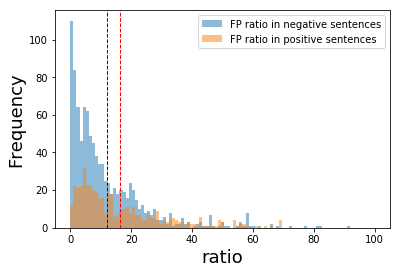

In [150]:
def getData(input_file):
    with open(input_file, 'r') as results:
        csv_reader = csv.reader(results, delimiter='\t')
        next(results)

        tokens = []
        predictions = []
        groundtruths = []
        

        for row in csv_reader:
            index = row[0]
            token = row[1]
            predicted = row[2]
            groundtruth = row[3]

            tokens.append(token)

            if '[CLS]' in token:
                predictions.append('[CLS]')
                groundtruths.append('[CLS]')
            else:
                predictions.append(predicted)
                groundtruths.append(groundtruth)
                
    tokens_ = isplit(tokens ,('[CLS]',))
    predictions_ = isplit(predictions ,('[CLS]',))
    groundtruths_ = isplit(groundtruths ,('[CLS]',))
    
    dataSanityCheck(tokens_, predictions_, groundtruths_)
    print('Sanity check done....all lengths identical')
    
    fp_ratio_neg, fp_ratio_pos, errors_neg_dict, errors_pos_dict, predictions_neg, predictions_pos = getStats(tokens_, predictions_, groundtruths_)
    
    plotData(fp_ratio_neg, fp_ratio_pos, 'ratio')    
    
    #plotData(predictions_neg, predictions_pos, 'ratio') 
    
getData(hilfiker_results)